In [ ]:
!pip install --force tqdm==4.24.0

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
!git clone https://github.com/ju-leon/RetouchML.git

Cloning into 'RetouchML'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 153 (delta 53), reused 148 (delta 48), pack-reused 0
Receiving objects: 100% (153/153), 11.27 MiB | 7.21 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [3]:
%cd RetouchML/

/Users/leon/Files/stylegan2encoder/RetouchML


In [1]:
%ls

Beautify.ipynb                   fit_faces.py
Dockerfile*                      generated_images/
LICENSE.txt*                     latent_representations/
README.md*                       masks/
StyleGAN_Encoder_Tutorial.ipynb  metrics/
__pycache__/                     out/
adaptive.py                      pretrained_networks.py*
align_images.py*                 projector.py*
aligned_images/                  raw_images/
alignement_vector/               robust_loss/
cache/                           run_generator.py*
data/                            run_metrics.py*
dataset_tool.py*                 run_projector.py*
dnnlib/                          run_training.py*
docs/                            swa.py
encode_images.py*                test_nvcc.cu*
encoder/                         training/
ffhq_dataset/                    videos/


In [2]:
!mkdir aligned_images raw_images alignement_vector out

mkdir: aligned_images: File exists
mkdir: raw_images: File exists
mkdir: alignement_vector: File exists
mkdir: out: File exists


In [3]:
import glob, os
import PIL.Image

In [4]:
%ls

Beautify.ipynb                   fit_faces.py
Dockerfile*                      generated_images/
LICENSE.txt*                     latent_representations/
README.md*                       masks/
StyleGAN_Encoder_Tutorial.ipynb  metrics/
__pycache__/                     out/
adaptive.py                      pretrained_networks.py*
align_images.py*                 projector.py*
aligned_images/                  raw_images/
alignement_vector/               robust_loss/
cache/                           run_generator.py*
data/                            run_metrics.py*
dataset_tool.py*                 run_projector.py*
dnnlib/                          run_training.py*
docs/                            swa.py
encode_images.py*                test_nvcc.cu*
encoder/                         training/
ffhq_dataset/                    videos/


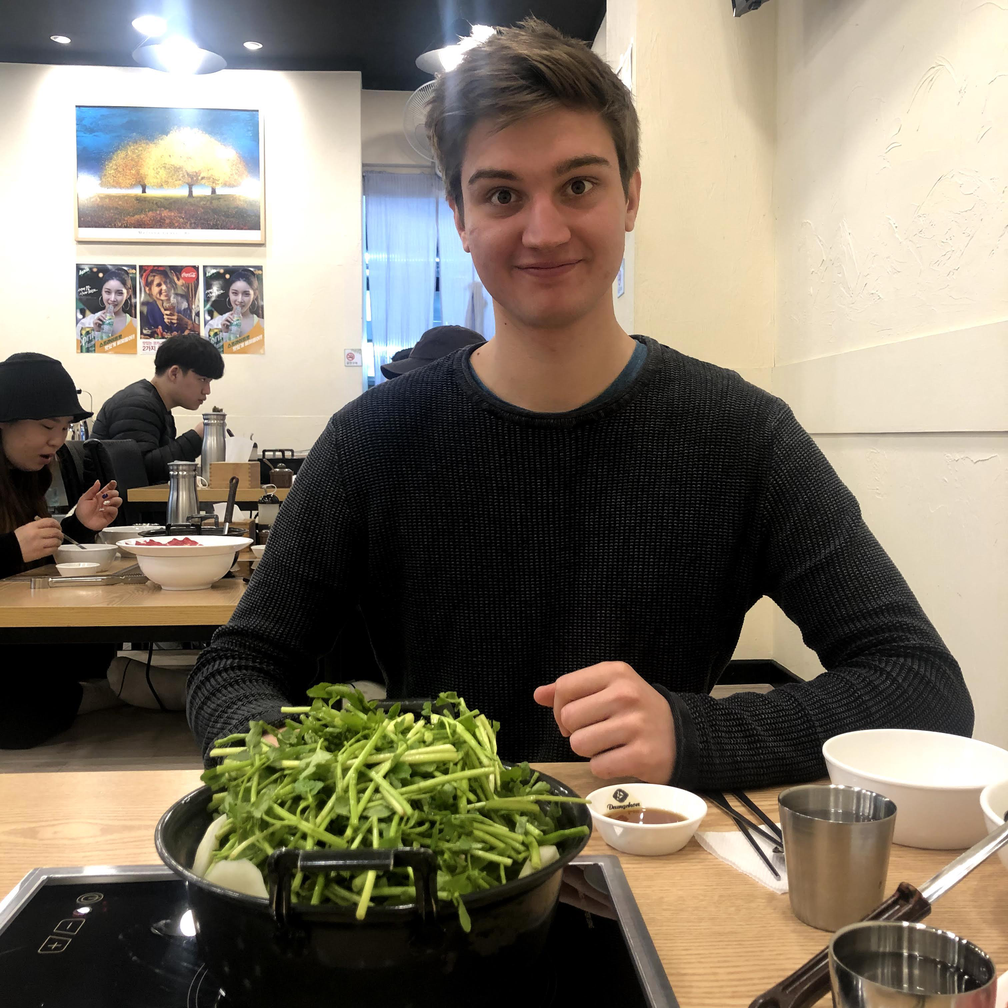

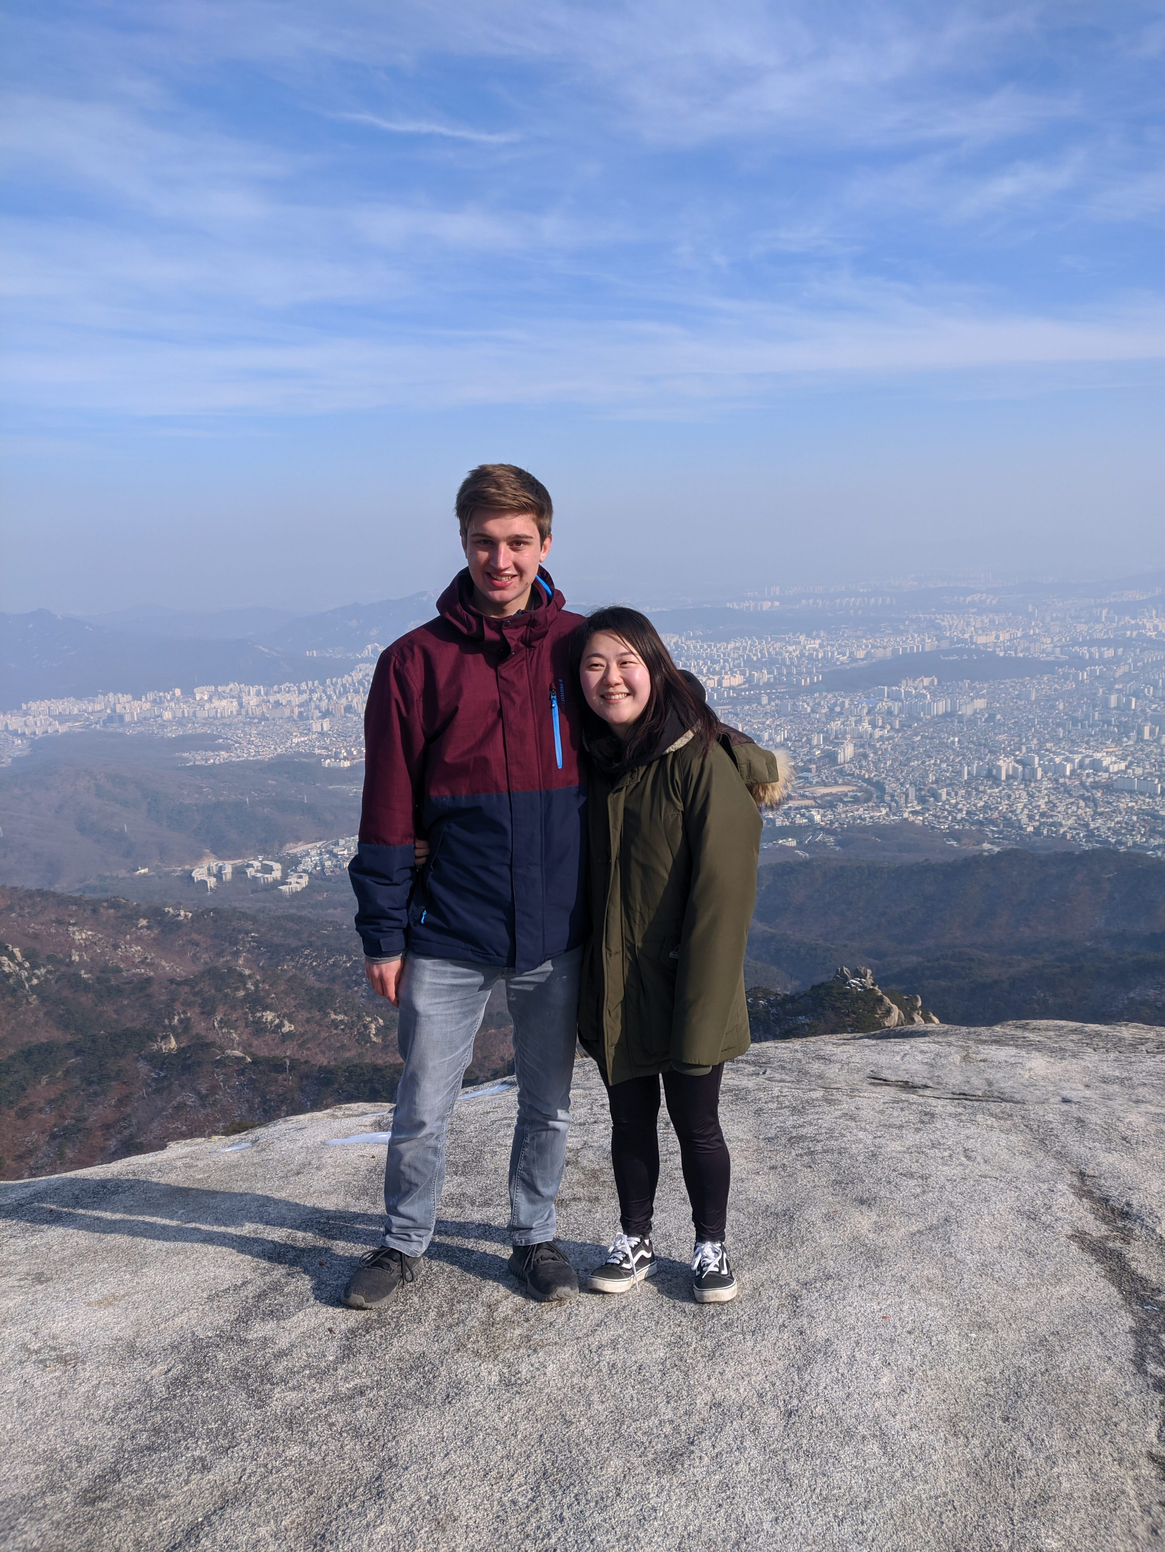

In [7]:
path = "raw_images/"
valid_images = (".jpg",".png")
for f in os.listdir(path):
    if f.endswith(valid_images):
        img = PIL.Image.open(path + f)
        display(img.resize((int(img.size[0]/3), int(img.size[1]/3)), PIL.Image.LANCZOS))


In [8]:
!python align_images.py raw_images/ aligned_images/ alignement_vector/

Using TensorFlow backend.


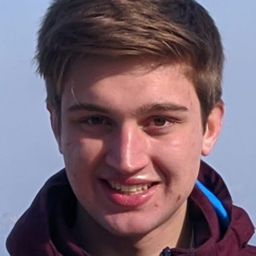

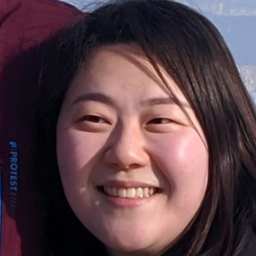

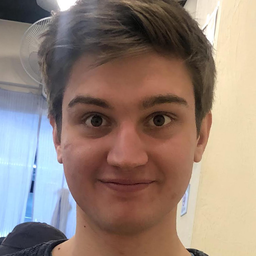

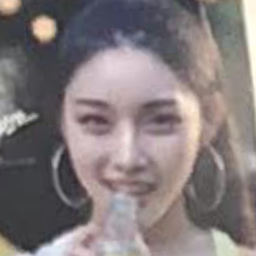

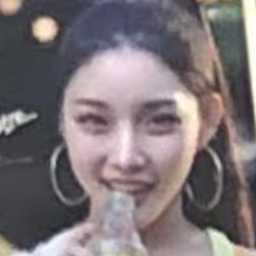

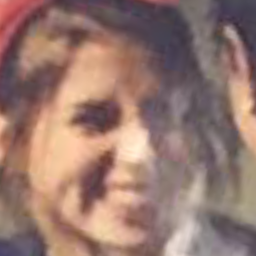

In [9]:
path = "aligned_images/"
for f in os.listdir(path):
    if f.endswith(valid_images):
        img = PIL.Image.open(path + f)
        display(img.resize((256,256), PIL.Image.LANCZOS))

In [57]:
!python encode_images.py --help

Using TensorFlow backend.
usage: encode_images.py [-h] [--data_dir DATA_DIR] [--mask_dir MASK_DIR]
                        [--load_last LOAD_LAST] [--dlatent_avg DLATENT_AVG]
                        [--model_url MODEL_URL] [--model_res MODEL_RES]
                        [--batch_size BATCH_SIZE] [--optimizer OPTIMIZER]
                        [--vgg_url VGG_URL] [--image_size IMAGE_SIZE]
                        [--resnet_image_size RESNET_IMAGE_SIZE] [--lr LR]
                        [--decay_rate DECAY_RATE] [--iterations ITERATIONS]
                        [--decay_steps DECAY_STEPS]
                        [--early_stopping [EARLY_STOPPING]]
                        [--early_stopping_threshold EARLY_STOPPING_THRESHOLD]
                        [--early_stopping_patience EARLY_STOPPING_PATIENCE]
                        [--load_effnet LOAD_EFFNET]
                        [--load_resnet LOAD_RESNET]
                        [--use_preprocess_input [USE_PREPROCESS_INPUT]]
                 

In [58]:
!python encode_images.py aligned_images/ generated_images/ latent_representations/ \
    --vgg_url=https://rolux.org/media/stylegan/vgg16_zhang_perceptual.pkl \
    --lr=0.25 --iterations=1000 --use_l1_penalty=0.5

Using TensorFlow backend.
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Failed!
Traceback (most recent call last):
  File "encode_images.py", line 243, in <module>
    main()
  File "encode_images.py", line 116, in main
    generator_network, discriminator_network, Gs_network = pretrained_networks.load_networks(args.model_url)
  File "/Users/leon/Files/stylegan2encoder/pretrained_networks.py", line 76, in load_networks
    G, D, Gs = pickle.load(stream, encoding='latin1')
  File "/Users/leon/Files/stylegan2encoder/dnnlib/tflib/network.py", line 297, in __setstate__
    self._init_graph()
  File "/Users/leon/Files/stylegan2encoder/dnnlib/tflib/network.py", line 154, in _init_graph
    out_expr = self._build_func(*self.input_templates, **build_kwargs)
  File "<string>", line 491, in G_synthesis_stylegan2
  File "<string>", line 455, in layer
  File "<string>", line 99, in modulated_conv2d_layer
  File "<string>", line 68, in apply_bias_act
  File "/Users/leon/Files/s

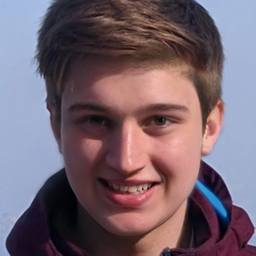

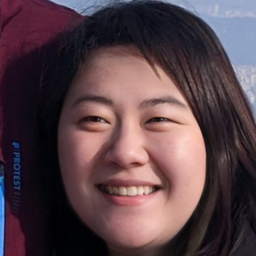

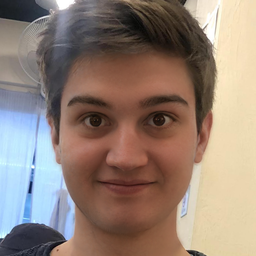

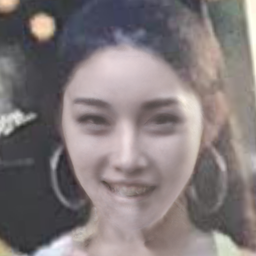

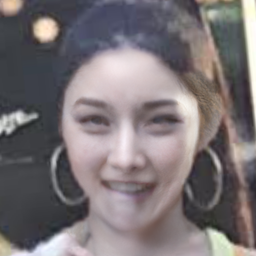

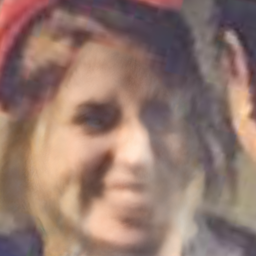

In [11]:
path = "generated_images/"
for f in os.listdir(path):
    if f.endswith(valid_images):
        img = PIL.Image.open(path + f)
        display(img.resize((256,256), PIL.Image.LANCZOS))

In [7]:
import math
import pickle
import PIL.Image
import numpy as np
#import config
import dnnlib
import dnnlib.tflib as tflib
from encoder.generator_model import Generator
URL_FFHQ = 'http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl'
tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir="cache") as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)

model_res = 1024
model_scale = int(2*(math.log(model_res,2)-1))

def generate_raw_image(latent_vector):
    latent_vector = latent_vector.reshape((1, model_scale, 512))
    generator.set_dlatents(latent_vector)
    return generator.generate_images()[0]

def generate_image(latent_vector):
    img_array = generate_raw_image(latent_vector)
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Failed!


RuntimeError: NVCC returned an error. See below for full command line and output log:

nvcc "/Users/leon/Files/stylegan2encoder/dnnlib/tflib/ops/fused_bias_act.cu" --preprocess -o "/var/folders/lr/ntqbj1157_9852p7sttscy5r0000gn/T/tmp6yc2r4ry/fused_bias_act_tmp.cu" --keep --keep-dir "/var/folders/lr/ntqbj1157_9852p7sttscy5r0000gn/T/tmp6yc2r4ry" --disable-warnings --include-path "/Users/leon/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/include" --include-path "/Users/leon/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/include/external/protobuf_archive/src" --include-path "/Users/leon/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/include/external/com_google_absl" --include-path "/Users/leon/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/include/external/eigen_archive" 2>&1

/bin/sh: nvcc: command not found


In [ ]:
s1 = np.load('latent_representations/20200319_145248_04.npy')
s2 = np.load('latent_representations/20200319_145248_02.npy')
#s1 = np.expand_dims(s1,axis=0)
#s2 = np.expand_dims(s2,axis=0)

#s2 = np.random.randn(18,512)
print(s2.shape)
display(generate_image(0*s1+1*s2).resize((512,512),PIL.Image.LANCZOS))

In [13]:
import os
import sys
import bz2
from keras.utils import get_file
from ffhq_dataset.face_alignment import image_align
from ffhq_dataset.landmarks_detector import LandmarksDetector

Using TensorFlow backend.


In [15]:
def unpack_bz2(src_path):
    data = bz2.BZ2File(src_path).read()
    dst_path = src_path[:-4]
    with open(dst_path, 'wb') as fp:
        fp.write(data)
    return dst_path


In [17]:
LANDMARKS_MODEL_URL = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
landmarks_model_path = unpack_bz2('models/shape_predictor_68_face_landmarks.dat.bz2')

landmarks_detector = LandmarksDetector(landmarks_model_path)


In [31]:
landmarks = landmarks_detector.get_landmarks("generated_images/IMG_20200209_150540_01.png")

for i, face_landmarks in enumerate(landmarks, start=1):
    print(face_landmarks)

ValueError: not enough values to unpack (expected 2, got 1)

In [68]:
from shutil import copyfile

img_name = "20200319_145248.jpg"

raw_path = "raw_images/" + img_name
out_path = "out/" + img_name
face_path = "generated_images/" 
mask_path = "masks/"
vector_path = "alignement_vector/"
!python fit_faces.py $raw_path $face_path $mask_path $vector_path $out_path


Using TensorFlow backend.


In [47]:
import ntpath

In [37]:
os.path.basename("sdkfh/test.png")

'test.png'